**1. Load Libraries and Path**

In [ ]:
!pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Embedding, GRU, Conv1D
from tensorflow.keras.layers import SpatialDropout1D, LSTM, Activation, Bidirectional, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [ ]:
FOLDER_PATH = '/content/drive/MyDrive/final_project/data'
CHECKPOINT_PATH = '/content/drive/MyDrive/final_project/checkpoint'

TRAINING_DATA_PATH = os.path.join(FOLDER_PATH, 'preprocessed_train.csv')
VALID_DATA_PATH    = os.path.join(FOLDER_PATH, 'preprocessed_valid.csv')
TEST_DATA_PATH     = os.path.join(FOLDER_PATH, 'preprocessed_test.csv')

**2. Load Data**

In [ ]:
train_df = pd.read_csv(TRAINING_DATA_PATH)
print(f"train shape : {train_df.shape}")

valid_df = pd.read_csv(VALID_DATA_PATH)
print(f"train shape : {valid_df.shape}")

test_df = pd.read_csv(TEST_DATA_PATH)
print(f"train shape : {test_df.shape}")

train shape : (35986, 3)
train shape : (5125, 3)
train shape : (10159, 3)


**3. Sentence len checking**

In [ ]:
## get word length for each row
train_df['len'] = train_df['text_preprocessed'].apply(lambda x : len(x.split()))

## get description
train_df['len'].describe()

count    35986.000000
mean       274.708803
std        226.288015
min          2.000000
25%        136.000000
50%        222.000000
75%        355.000000
max       9386.000000
Name: len, dtype: float64

*As we can see the maximum word length is 9386 which is very high as compared to the 75 percentile which is 355. We must further analyse the data to understand the distribution.*

In [ ]:
## checking percentile for sentence length
train_df['len'].describe([0, 0.2, 0.4, 0.6, 0.8,
                          0.9,0.92, 0.94, 0.96, 
                          0.98, 0.99, 0.991, 0.993,
                          0.995, 0.997, 0.999, 1]).transpose()

count    35986.000000
mean       274.708803
std        226.288015
min          2.000000
0%           2.000000
20%        119.000000
40%        186.000000
50%        222.000000
60%        266.000000
80%        394.000000
90%        514.000000
92%        554.000000
94%        607.000000
96%        685.000000
98%        839.000000
99%       1063.000000
99.1%     1095.000000
99.3%     1197.000000
99.5%     1333.225000
99.7%     1532.315000
99.9%     2272.300000
100%      9386.000000
max       9386.000000
Name: len, dtype: float64

In [ ]:
## keeping 512 as the threshold words
## it will keep 90% of the rows for all words
thresh_pcnt = train_df[train_df['len'] > 512].shape[0]/train_df.shape[0]
print(f"percentage of row which will exceed 512 words : {thresh_pcnt * 100 : .2f}%")

percentage of row which will exceed 512 words :  10.06%


**4. Model Setting**

In [ ]:
max_word_len = 512
embedding_dim = 50

**5. Tokenizing Data**

In [ ]:
## creating object for tokenization
model_token = Tokenizer()

model_token.fit_on_texts(train_df["text_preprocessed"])

X_train = model_token.texts_to_sequences(train_df["text_preprocessed"])
X_valid = model_token.texts_to_sequences(valid_df["text_preprocessed"])
X_test  = model_token.texts_to_sequences(test_df["text_preprocessed"])

In [ ]:
## get vocab size
vocab_size = len(model_token.word_index) + 1
print(f"Vocab Size : {vocab_size}")

Vocab Size : 166960


**6. Sequence Padding**

In [ ]:
## sequence padding on the input texts
X_train_pad = pad_sequences(X_train, maxlen = max_word_len, padding='post')
X_valid_pad = pad_sequences(X_valid, maxlen = max_word_len, padding='post')
X_test_pad  = pad_sequences(X_test, maxlen = max_word_len, padding='post')

In [ ]:

print(X_train_pad.shape, X_valid_pad.shape, X_test_pad.shape)

(35986, 512) (5125, 512) (10159, 512)


**7. Output Data**

In [ ]:
Y_train = train_df['propaganda_label'].map({-1 : 0, 1 : 1})
Y_valid = valid_df['propaganda_label'].map({-1 : 0, 1 : 1})
Y_test  = test_df['propaganda_label'].map({-1 : 0, 1 : 1})

print(Y_train.shape, Y_valid.shape, Y_test.shape)

(35986,) (5125,) (10159,)


**8. Callbacks**

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.callbacks import Callback

class accuracy_value(Callback):

    def __init__(self, training_data, validation_data):
        self.X_train = training_data[0]
        self.y_train = training_data[1]
        self.X_val = validation_data[0]
        self.y_val = validation_data[1]

    def on_train_begin(self, logs = {}):
        self.f1_scores = []
        self.precisions = []
        self.recalls = []

    def on_epoch_end(self, epoch, logs = {}):
        
        #F1 Score
        y_predicted = np.asarray(self.model.predict(self.X_val)).round()
        f1_val = f1_score(self.y_val,y_predicted,average=None)
        self.f1_scores.append(f1_val)

        print(" - F1_Score : {}".format(np.round(f1_val,4)))

**9. LSTM Modelling**

In [ ]:
def lstm_modelling(vocab_size, embedding_dim = 50, max_word_len = 512,
                   num_layers = 2, optimizer = 'rmsprop'):

    ## setting up sequential model
    model = Sequential()
    ## embedding layer
    model.add(Embedding(vocab_size, embedding_dim, weights = None,
                        input_length = max_word_len, trainable=True))
    ## lstm model with 
    model.add(LSTM(num_layers, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    ## compile model
    model.compile(loss = "binary_crossentropy",
                optimizer = optimizer,
                metrics = ["accuracy"]) #compile the model
    
    return model

***9.1 Train Model***

In [ ]:
## saving model checkpoints
log_dir_checkpoint_v1 = os.path.join(CHECKPOINT_PATH, datetime.datetime.now().strftime("%H%M%S"))
checkpoint = ModelCheckpoint(log_dir_checkpoint_v1, monitor="val_loss", verbose=2, save_best_only=True,)
print(log_dir_checkpoint_v1)

## f1 score set up
F1_Score = accuracy_value(training_data   = (X_train_pad, Y_train),
                          validation_data = (X_valid_pad, Y_valid))

## early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=2, mode='auto') 

## setting up model
lstm_model = lstm_modelling(vocab_size)

## training model
history = lstm_model.fit(X_train_pad, Y_train, validation_data=(X_valid_pad, Y_valid),
                    batch_size=128, verbose=2, epochs=10,
                    callbacks = [F1_Score, checkpoint, early_stop])

lstm_model.load_weights(log_dir_checkpoint_v1)

/content/drive/MyDrive/final_project/checkpoint/143836
Epoch 1/10
161/161 [==============================] - 2s 8ms/step
 - F1_Score : [0.9731 0.7698]

Epoch 1: val_loss improved from inf to 0.13197, saving model to /content/drive/MyDrive/final_project/checkpoint/143836


282/282 - 18s - loss: 0.1951 - accuracy: 0.9271 - val_loss: 0.1320 - val_accuracy: 0.9518 - 18s/epoch - 64ms/step
Epoch 2/10
161/161 [==============================] - 1s 7ms/step
 - F1_Score : [0.9766 0.7844]

Epoch 2: val_loss improved from 0.13197 to 0.12618, saving model to /content/drive/MyDrive/final_project/checkpoint/143836


282/282 - 13s - loss: 0.0995 - accuracy: 0.9638 - val_loss: 0.1262 - val_accuracy: 0.9579 - 13s/epoch - 45ms/step
Epoch 3/10
161/161 [==============================] - 1s 8ms/step
 - F1_Score : [0.9777 0.7964]

Epoch 3: val_loss did not improve from 0.12618
282/282 - 8s - loss: 0.0711 - accuracy: 0.9748 - val_loss: 0.1290 - val_accuracy: 0.9598 - 8s/epoch - 29ms/step
Epoch 4/10
161/161 [==============================] - 1s 8ms/step
 - F1_Score : [0.9771 0.8126]

Epoch 4: val_loss improved from 0.12618 to 0.12612, saving model to /content/drive/MyDrive/final_project/checkpoint/143836


282/282 - 17s - loss: 0.0517 - accuracy: 0.9823 - val_loss: 0.1261 - val_accuracy: 0.9592 - 17s/epoch - 61ms/step
Epoch 5/10
161/161 [==============================] - 1s 8ms/step
 - F1_Score : [0.9774 0.8123]

Epoch 5: val_loss did not improve from 0.12612
282/282 - 9s - loss: 0.0366 - accuracy: 0.9888 - val_loss: 0.1358 - val_accuracy: 0.9596 - 9s/epoch - 30ms/step
Epoch 6/10
161/161 [==============================] - 1s 7ms/step
 - F1_Score : [0.9776 0.8068]

Epoch 6: val_loss did not improve from 0.12612
282/282 - 8s - loss: 0.0245 - accuracy: 0.9920 - val_loss: 0.1535 - val_accuracy: 0.9598 - 8s/epoch - 28ms/step
Epoch 7/10
161/161 [==============================] - 1s 7ms/step
 - F1_Score : [0.9742 0.7944]

Epoch 7: val_loss did not improve from 0.12612
282/282 - 8s - loss: 0.0157 - accuracy: 0.9952 - val_loss: 0.1792 - val_accuracy: 0.9541 - 8s/epoch - 27ms/step
Epoch 7: early stopping


***9.2 Validation Plots***

In [ ]:
def accuracy_loss_plot(model,
                       keyword = ['loss', 'val_loss', 'accuracy', 'val_accuracy'],
                       figsize=(20,10)):
    ## setting size and epoch lendth
    plt.figure(figsize = figsize)
    epochs = range(2, len(model[keyword[0]])+1)
    
    ## plotting loss values 
    plt.subplot(221)
    plt.plot(epochs, model[keyword[0]][1:])
    plt.plot(epochs, model[keyword[1]][1:])
    plt.title('Loss', fontsize=30)
    plt.xlabel('epochs', fontsize=20)
    plt.legend(keyword[0:2], fontsize=20)

    ## plotting accuracy values
    plt.subplot(222)
    plt.plot(epochs, model[keyword[2]][1:])
    plt.plot(epochs, model[keyword[3]][1:])
    plt.title('Accuracy', fontsize=30)
    plt.xlabel('epochs', fontsize=20)
    plt.legend(keyword[2:], fontsize=20)

    return plt.show()

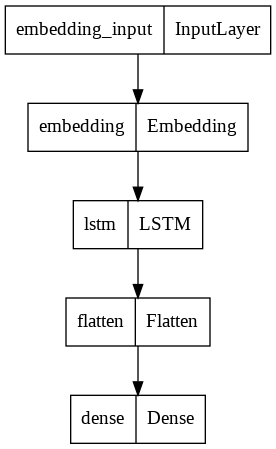

In [ ]:
tf.keras.utils.plot_model(lstm_model)

In [ ]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 50)           8348000   
                                                                 
 lstm (LSTM)                 (None, 512, 2)            424       
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 8,349,449
Trainable params: 8,349,449
Non-trainable params: 0
_________________________________________________________________


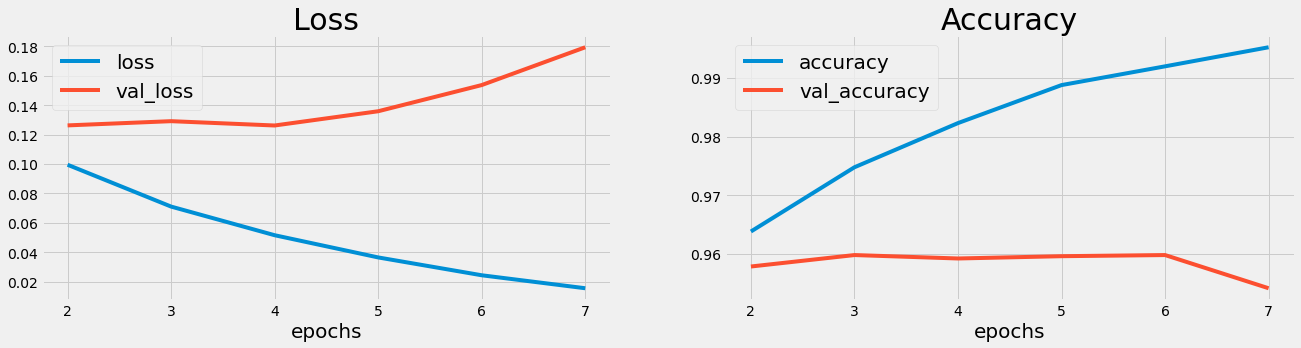

In [ ]:
accuracy_loss_plot(history.history)

***9.3 prediction on test dataset***

In [ ]:
def get_plots(ytrain, ytest, ytrain_proba, ytest_proba, ytrain_pred, ytest_pred):
    """
    This function generates roc_auc_curve and confusion matrix.
    """
    class_report = metrics.classification_report(ytest, ytest_pred)
    print("-------------------------------------Classification Report---------------------------------------")
    print(class_report)
    
    fig = plt.figure(figsize=(15,10))
    
    ## generate tpr, fpr scores for different threshold of probability
    ## for roc auc curve
    fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(ytrain, ytrain_proba)
    fpr_te, tpr_te, threshold_te = metrics.roc_curve(ytest, ytest_proba)
    
    ## get auc score
    auc_train = metrics.auc(fpr_tr, tpr_tr)
    auc_test = metrics.auc(fpr_te, tpr_te)
    
    ## plot roc curves
    plt.subplot(221)
    plt.plot(fpr_tr, tpr_tr, label = "train auc - " + str(round(auc_train,2)))
    plt.plot(fpr_te, tpr_te, label = "test auc - "  + str(round(auc_test ,2)))
    plt.legend()
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.title('ROC Curve', fontsize=20)
    
    ## plot roc auc score
    plt.subplot(222)
    conf_matrix = metrics.confusion_matrix(ytest, ytest_pred)
    plot = sns.heatmap(conf_matrix, cbar=False, fmt = '2g', annot=True, cmap = 'Blues')
    plt.title("Confusion Matrix", fontsize=20)
    plt.xlabel('Predicted', fontsize=20)
    plt.ylabel('Actuals', fontsize=20)
    
    plt.show()

In [ ]:
def get_scores(model_name, ytrain, ytest, ytrain_pred, ytest_pred, 
               ytrain_pred_proba, ytest_pred_proba):
    
    ## empty list to append scores
    scores = {}
    
    ## predicted class values
    class0_total = ytest.value_counts().values[0]
    class1_total = ytest.value_counts().values[1]
    
    ## confusion matrix output
    class0_pred = metrics.confusion_matrix(ytest, ytest_pred)[0][0]
    class1_pred = metrics.confusion_matrix(ytest, ytest_pred)[1][1]
    
    ## get individual accuracy score
    not_propaganda_acc = round((class0_pred/class0_total), 4)
    propaganda_acc    = round((class1_pred/class1_total), 4)
    
    ## get prediction
    train_acc = float("{:.4f}".format(metrics.accuracy_score(ytrain, ytrain_pred)))
    test_acc = float("{:.4f}".format(metrics.accuracy_score(ytest, ytest_pred)))
    test_f1 = float("{:.4f}".format(metrics.f1_score(ytest, ytest_pred)))
    test_precision = float("{:.4f}".format(metrics.precision_score(ytest, ytest_pred)))
    test_recall = float("{:.4f}".format(metrics.recall_score(ytest, ytest_pred)))
    test_roc_score = float("{:.4f}".format(metrics.roc_auc_score(ytest, ytest_pred)))
    
    ## get roc auc scores
    fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(ytrain,  ytrain_pred_proba)
    auc_train = round(metrics.auc(fpr_tr, tpr_tr), 4)
    fpr_te, tpr_te, threshold_te = metrics.roc_curve(ytest,  ytest_pred_proba)
    auc_test = round(metrics.auc(fpr_te, tpr_te), 4)
    
    scores['model_name'] = model_name
    scores['accuracy'] = test_acc
    scores['auc'] = auc_test
    scores['not_propaganda_accuracy'] = not_propaganda_acc
    scores['propaganda_accuracy'] = propaganda_acc
    scores['f1'] = test_f1
    scores['precision'] = test_precision
    scores['recall'] = test_recall
    scores['roc'] = test_roc_score
    
    return scores

In [ ]:
## get predictions
Y_train_pred_proba = lstm_model.predict(X_train_pad, verbose=0)
Y_valid_pred_proba = lstm_model.predict(X_valid_pad, verbose=0)

## get class labels
Y_train_pred = np.where(Y_train_pred_proba > 0.50, 1, 0)
Y_valid_pred = np.where(Y_valid_pred_proba > 0.50, 1, 0)

-------------------------------------Classification Report---------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4550
           1       0.84      0.79      0.81       575

    accuracy                           0.96      5125
   macro avg       0.91      0.88      0.89      5125
weighted avg       0.96      0.96      0.96      5125



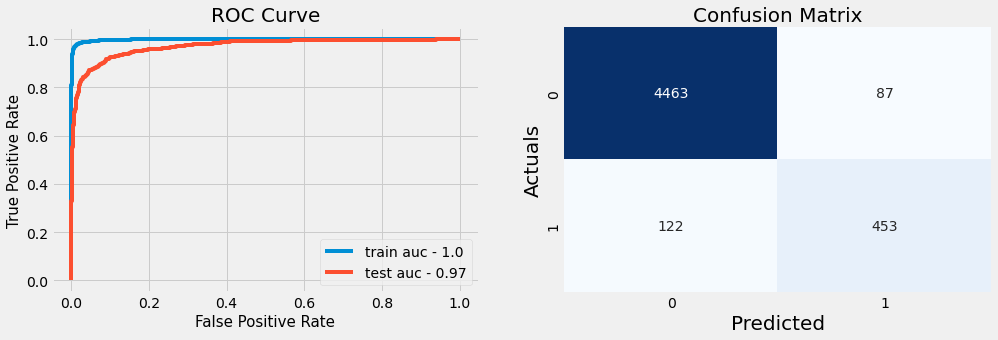

In [ ]:
score_lstm = get_scores('LSTM Model', Y_train, Y_valid, Y_train_pred, Y_valid_pred,
                        Y_train_pred_proba, Y_valid_pred_proba)

get_plots(Y_train, Y_valid, 
          Y_train_pred_proba, Y_valid_pred_proba,
          Y_train_pred, Y_valid_pred)

**10. GRU Modelling**

In [ ]:
def gru_modelling(vocab_size, embedding_dim = 50, max_word_len = 512,
                   num_layers = 2, optimizer = 'rmsprop'):

    ## setting up sequential model
    model = Sequential()
    ## embedding layer
    model.add(Embedding(vocab_size, embedding_dim, weights = None,
                        input_length = max_word_len, trainable=True))
    ## gru model 
    model.add(GRU(num_layers, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    ## compile model
    model.compile(loss = "binary_crossentropy",
                optimizer = optimizer,
                metrics = ["accuracy"]) #compile the model
    
    return model

***10.1 Training Model***

In [ ]:
## saving model checkpoints
log_dir_checkpoint_v2 = os.path.join(CHECKPOINT_PATH, datetime.datetime.now().strftime("%H%M%S"))
checkpoint = ModelCheckpoint(log_dir_checkpoint_v2, monitor="val_loss", verbose=2,
                             save_best_only=True,)
print(log_dir_checkpoint_v2)

## f1 score set up
F1_Score = accuracy_value(training_data   = (X_train_pad, Y_train),
                          validation_data = (X_valid_pad, Y_valid))

## early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=2, mode='auto') 

## setting up model
gru_model = gru_modelling(vocab_size)

## training model
history1 = gru_model.fit(X_train_pad, Y_train, validation_data=(X_valid_pad, Y_valid),
                        batch_size=128, verbose=2, epochs=10,
                        callbacks = [F1_Score, checkpoint, early_stop])

## get best model
gru_model.load_weights(log_dir_checkpoint_v2)

/content/drive/MyDrive/final_project/checkpoint/144012
Epoch 1/10
161/161 [==============================] - 2s 7ms/step
 - F1_Score : [0.9724 0.777 ]

Epoch 1: val_loss improved from inf to 0.14282, saving model to /content/drive/MyDrive/final_project/checkpoint/144012


282/282 - 15s - loss: 0.1987 - accuracy: 0.9262 - val_loss: 0.1428 - val_accuracy: 0.9508 - 15s/epoch - 52ms/step
Epoch 2/10
161/161 [==============================] - 1s 8ms/step
 - F1_Score : [0.9688 0.7721]

Epoch 2: val_loss did not improve from 0.14282
282/282 - 8s - loss: 0.1001 - accuracy: 0.9635 - val_loss: 0.1502 - val_accuracy: 0.9452 - 8s/epoch - 27ms/step
Epoch 3/10
161/161 [==============================] - 1s 8ms/step
 - F1_Score : [0.9771 0.8023]

Epoch 3: val_loss improved from 0.14282 to 0.12534, saving model to /content/drive/MyDrive/final_project/checkpoint/144012


282/282 - 13s - loss: 0.0740 - accuracy: 0.9741 - val_loss: 0.1253 - val_accuracy: 0.9590 - 13s/epoch - 47ms/step
Epoch 4/10
161/161 [==============================] - 1s 7ms/step
 - F1_Score : [0.9748 0.8031]

Epoch 4: val_loss did not improve from 0.12534
282/282 - 6s - loss: 0.0580 - accuracy: 0.9794 - val_loss: 0.1331 - val_accuracy: 0.9553 - 6s/epoch - 23ms/step
Epoch 5/10
161/161 [==============================] - 1s 8ms/step
 - F1_Score : [0.9776 0.8148]

Epoch 5: val_loss did not improve from 0.12534
282/282 - 7s - loss: 0.0468 - accuracy: 0.9841 - val_loss: 0.1310 - val_accuracy: 0.9600 - 7s/epoch - 23ms/step
Epoch 6/10
161/161 [==============================] - 1s 8ms/step
 - F1_Score : [0.9765 0.7923]

Epoch 6: val_loss did not improve from 0.12534
282/282 - 8s - loss: 0.0373 - accuracy: 0.9876 - val_loss: 0.1481 - val_accuracy: 0.9579 - 8s/epoch - 27ms/step
Epoch 6: early stopping


***10.2 Validation Plots***

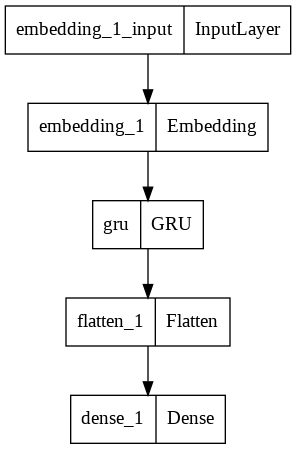

In [ ]:
tf.keras.utils.plot_model(gru_model)

In [ ]:
gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 512, 50)           8348000   
                                                                 
 gru (GRU)                   (None, 512, 2)            324       
                                                                 
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 8,349,349
Trainable params: 8,349,349
Non-trainable params: 0
_________________________________________________________________


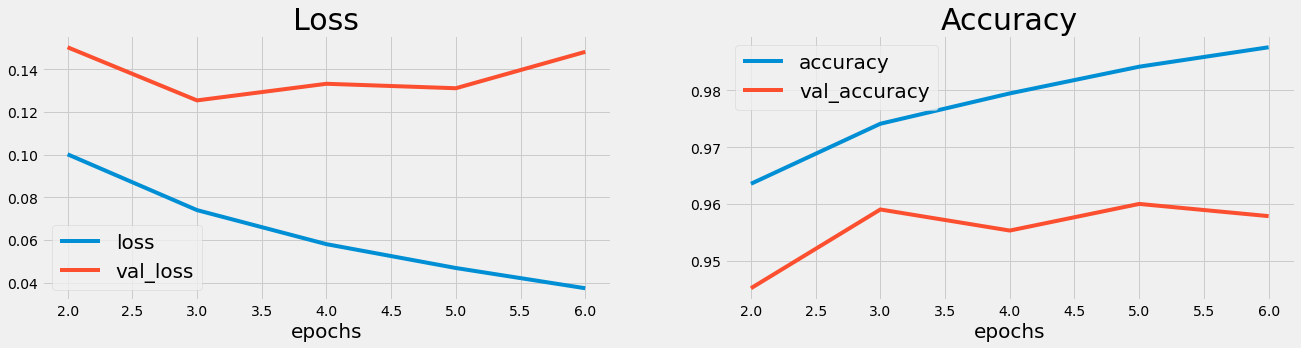

In [ ]:
accuracy_loss_plot(history1.history)

***10.3 prediction on test dataset***

In [ ]:
## get predictions
Y_train_pred_proba = gru_model.predict(X_train_pad, verbose=0)
Y_valid_pred_proba = gru_model.predict(X_valid_pad, verbose=0)

## get class labels
Y_train_pred = np.where(Y_train_pred_proba > 0.50, 1, 0)
Y_valid_pred = np.where(Y_valid_pred_proba > 0.50, 1, 0)

-------------------------------------Classification Report---------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4550
           1       0.87      0.74      0.80       575

    accuracy                           0.96      5125
   macro avg       0.92      0.86      0.89      5125
weighted avg       0.96      0.96      0.96      5125



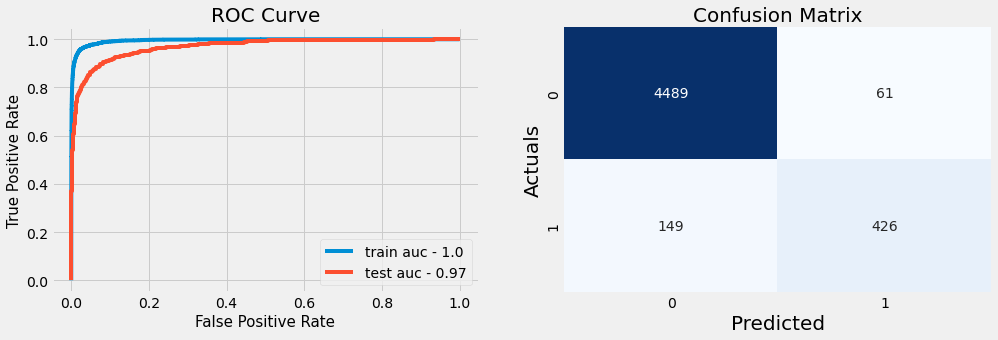

In [ ]:
score_gru = get_scores('GRU Model', Y_train, Y_valid, Y_train_pred, Y_valid_pred,
                        Y_train_pred_proba, Y_valid_pred_proba)

get_plots(Y_train, Y_valid,
          Y_train_pred_proba, Y_valid_pred_proba,
          Y_train_pred, Y_valid_pred)

**11. CONV-LSTM Model**

In [ ]:
def conv_lstm_modelling(vocab_size, embedding_dim = 50, max_word_len = 512,
                        num_layers = 2, conv_filter = 4, conv_kernel = 5, 
                        conv_activation = 'relu', conv_stride = 2,
                        optimizer = 'rmsprop'):
    
    """This function implements a convolution lstm model."""
    input = Input(shape = (max_word_len, ))
    x = Embedding(vocab_size, embedding_dim, weights = None, 
                  input_length = max_word_len, trainable=True)(input)
    
    ## convolution layers
    x1 = Conv1D(conv_filter, conv_kernel, padding='same',
                activation = conv_activation, strides = conv_stride)(x)
    x2 = Conv1D(conv_filter, conv_kernel, padding='same',
                activation = conv_activation, strides = conv_stride)(x)
    x3 = Conv1D(conv_filter, conv_kernel, padding='same',
                activation = conv_activation, strides = conv_stride)(x)
    
    ## add three convolution layer into one by concatenating them
    x = Concatenate()([x1, x2, x3])

    ## add lstm layer
    x = LSTM(num_layers, return_sequences=True)(x)
    x = Flatten()(x)
    x = Dropout(0.20)(x)
    output = Dense(1, activation='sigmoid')(x)

    ## final model set-up
    model = Model(input, output)

    ## compile model
    model.compile(loss = "binary_crossentropy", optimizer = optimizer,
                  metrics = ["accuracy"])
    
    return model

***11.1 Training Model***

In [ ]:
## saving model checkpoints
log_dir_checkpoint_v3 = os.path.join(CHECKPOINT_PATH, datetime.datetime.now().strftime("%H%M%S"))
checkpoint = ModelCheckpoint(log_dir_checkpoint_v3, monitor="val_loss", verbose=2,
                             save_best_only=True,)
print(log_dir_checkpoint_v3)

## f1 score set up
F1_Score = accuracy_value(training_data   = (X_train_pad, Y_train),
                          validation_data = (X_valid_pad, Y_valid))

## early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=2, mode='auto') 

## setting up model
conv_lstm_model = conv_lstm_modelling(vocab_size)

## training model
history2 = conv_lstm_model.fit(X_train_pad, Y_train, validation_data=(X_valid_pad, Y_valid),
                               batch_size=128, verbose=2, epochs=10, 
                               callbacks = [F1_Score, checkpoint, early_stop])

## get best model
conv_lstm_model.load_weights(log_dir_checkpoint_v3)

/content/drive/MyDrive/final_project/checkpoint/144121
Epoch 1/10
161/161 [==============================] - 1s 6ms/step
 - F1_Score : [0.9731 0.7689]

Epoch 1: val_loss improved from inf to 0.13206, saving model to /content/drive/MyDrive/final_project/checkpoint/144121


282/282 - 15s - loss: 0.1964 - accuracy: 0.9261 - val_loss: 0.1321 - val_accuracy: 0.9518 - 15s/epoch - 54ms/step
Epoch 2/10
161/161 [==============================] - 1s 6ms/step
 - F1_Score : [0.9748 0.7982]

Epoch 2: val_loss improved from 0.13206 to 0.12655, saving model to /content/drive/MyDrive/final_project/checkpoint/144121


282/282 - 12s - loss: 0.0927 - accuracy: 0.9675 - val_loss: 0.1265 - val_accuracy: 0.9551 - 12s/epoch - 41ms/step
Epoch 3/10
161/161 [==============================] - 1s 5ms/step
 - F1_Score : [0.9784 0.8203]

Epoch 3: val_loss did not improve from 0.12655
282/282 - 6s - loss: 0.0553 - accuracy: 0.9810 - val_loss: 0.1309 - val_accuracy: 0.9614 - 6s/epoch - 22ms/step
Epoch 4/10
161/161 [==============================] - 1s 5ms/step
 - F1_Score : [0.9555 0.7194]

Epoch 4: val_loss did not improve from 0.12655
282/282 - 7s - loss: 0.0288 - accuracy: 0.9903 - val_loss: 0.2348 - val_accuracy: 0.9231 - 7s/epoch - 24ms/step
Epoch 5/10
161/161 [==============================] - 1s 5ms/step
 - F1_Score : [0.9658 0.7573]

Epoch 5: val_loss did not improve from 0.12655
282/282 - 6s - loss: 0.0167 - accuracy: 0.9948 - val_loss: 0.2260 - val_accuracy: 0.9401 - 6s/epoch - 22ms/step
Epoch 5: early stopping


***11.2 Validation Plots***

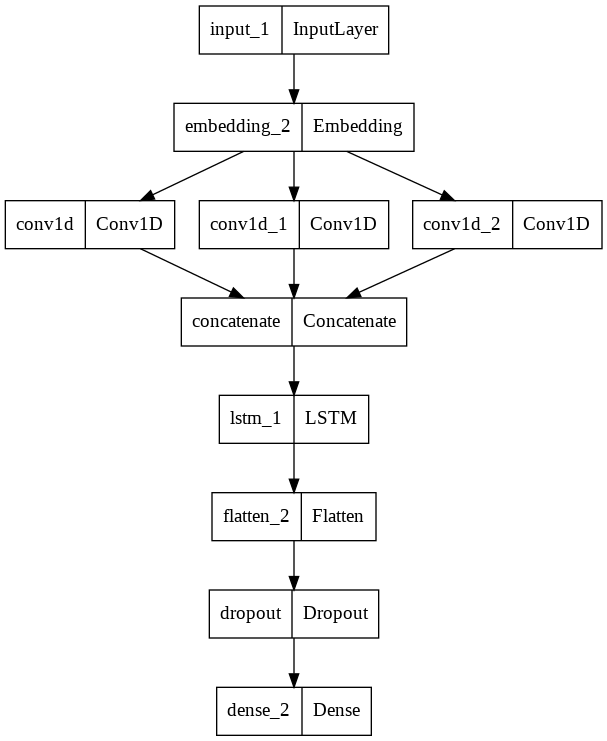

In [ ]:
tf.keras.utils.plot_model(conv_lstm_model)

In [ ]:
conv_lstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 512, 50)      8348000     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 256, 4)       1004        ['embedding_2[0][0]']            
                                                                                                  
 conv1d_1 (Conv1D)              (None, 256, 4)       1004        ['embedding_2[0][0]']            
                                                                                              

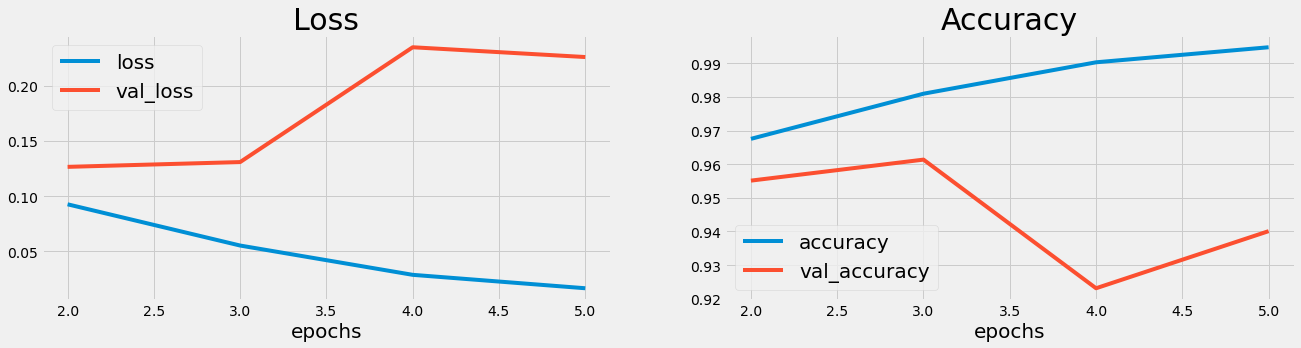

In [ ]:
accuracy_loss_plot(history2.history)

***11.3 prediction on test dataset***

In [ ]:
## get predictions
Y_train_pred_proba = conv_lstm_model.predict(X_train_pad, verbose=0)
Y_valid_pred_proba = conv_lstm_model.predict(X_valid_pad, verbose=0)

## get class labels
Y_train_pred = np.where(Y_train_pred_proba > 0.50, 1, 0)
Y_valid_pred = np.where(Y_valid_pred_proba > 0.50, 1, 0)

-------------------------------------Classification Report---------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      4550
           1       0.81      0.79      0.80       575

    accuracy                           0.96      5125
   macro avg       0.89      0.88      0.89      5125
weighted avg       0.95      0.96      0.95      5125



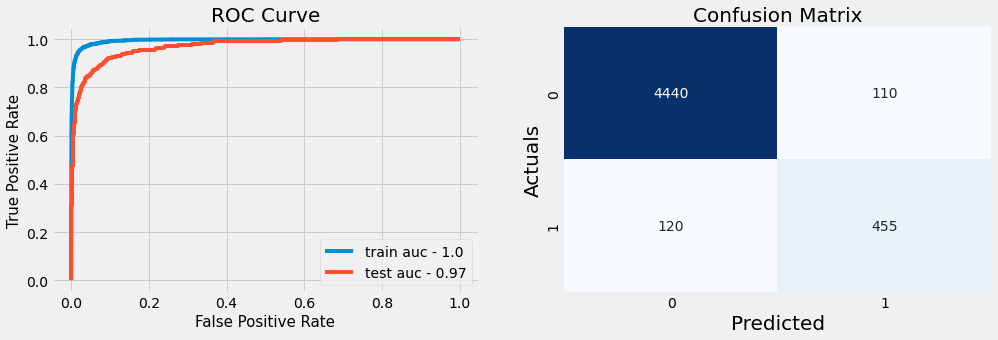

In [ ]:
score_conv_lstm = get_scores('CONV LSTM Model', Y_train, Y_valid,
                             Y_train_pred, Y_valid_pred,
                             Y_train_pred_proba, Y_valid_pred_proba)

get_plots(Y_train, Y_valid,
          Y_train_pred_proba, Y_valid_pred_proba,
          Y_train_pred, Y_valid_pred)

**12. CONV-GRU Model**

In [ ]:
def conv_gru_modelling(vocab_size, embedding_dim = 50, max_word_len = 512,
                       num_layers = 2, conv_filter = 4, conv_kernel = 5, 
                       conv_activation = 'relu', conv_stride = 2,
                       optimizer = 'rmsprop'):
    """This function implements a convolution gru model."""
    
    input = Input(shape = (max_word_len, ))
    x = Embedding(vocab_size, embedding_dim, weights = None, 
                  input_length = max_word_len, trainable=True)(input)
    
    ## convolution layers
    x1 = Conv1D(conv_filter, conv_kernel, padding='same',
                activation = conv_activation, strides = conv_stride)(x)
    x2 = Conv1D(conv_filter, conv_kernel, padding='same',
                activation = conv_activation, strides = conv_stride)(x)
    x3 = Conv1D(conv_filter, conv_kernel, padding='same',
                activation = conv_activation, strides = conv_stride)(x)
    
    ## add three convolution layer into one by concatenating them
    x = Concatenate()([x1, x2, x3])

    ## add lstm layer
    x = GRU(num_layers, return_sequences=True)(x)
    x = Flatten()(x)
    x = Dropout(0.20)(x)
    output = Dense(1, activation='sigmoid')(x)

    ## final model set-up
    model = Model(input, output)

    ## compile model
    model.compile(loss = "binary_crossentropy", optimizer = optimizer,
                  metrics = ["accuracy"])
    
    return model

***12.1 Training Model***

In [ ]:
## saving model checkpoints
log_dir_checkpoint_v4 = os.path.join(CHECKPOINT_PATH, datetime.datetime.now().strftime("%H%M%S"))
checkpoint = ModelCheckpoint(log_dir_checkpoint_v4, monitor="val_loss", verbose=2, save_best_only=True,)
print(log_dir_checkpoint_v4)

## f1 score set up
F1_Score = accuracy_value(training_data   = (X_train_pad, Y_train),
                          validation_data = (X_valid_pad, Y_valid))

## early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=2, mode='auto') 

## setting up model
conv_gru_model = conv_gru_modelling(vocab_size)

## training model
history3 = conv_gru_model.fit(X_train_pad, Y_train, validation_data=(X_valid_pad, Y_valid),
                               batch_size=128, verbose=2, epochs=10, 
                               callbacks = [F1_Score, checkpoint, early_stop])

## get best model
conv_gru_model.load_weights(log_dir_checkpoint_v4)

/content/drive/MyDrive/final_project/checkpoint/144258
Epoch 1/10
161/161 [==============================] - 2s 7ms/step
 - F1_Score : [0.9695 0.7073]

Epoch 1: val_loss improved from inf to 0.14384, saving model to /content/drive/MyDrive/final_project/checkpoint/144258


282/282 - 17s - loss: 0.2286 - accuracy: 0.9150 - val_loss: 0.1438 - val_accuracy: 0.9448 - 17s/epoch - 62ms/step
Epoch 2/10
161/161 [==============================] - 1s 5ms/step
 - F1_Score : [0.9752 0.7908]

Epoch 2: val_loss improved from 0.14384 to 0.12543, saving model to /content/drive/MyDrive/final_project/checkpoint/144258


282/282 - 11s - loss: 0.1054 - accuracy: 0.9610 - val_loss: 0.1254 - val_accuracy: 0.9557 - 11s/epoch - 39ms/step
Epoch 3/10
161/161 [==============================] - 1s 5ms/step
 - F1_Score : [0.9775 0.8053]

Epoch 3: val_loss did not improve from 0.12543
282/282 - 6s - loss: 0.0711 - accuracy: 0.9750 - val_loss: 0.1257 - val_accuracy: 0.9596 - 6s/epoch - 22ms/step
Epoch 4/10
161/161 [==============================] - 1s 5ms/step
 - F1_Score : [0.9489 0.7014]

Epoch 4: val_loss did not improve from 0.12543
282/282 - 6s - loss: 0.0456 - accuracy: 0.9839 - val_loss: 0.2465 - val_accuracy: 0.9128 - 6s/epoch - 22ms/step
Epoch 5/10
161/161 [==============================] - 1s 5ms/step
 - F1_Score : [0.9751 0.8065]

Epoch 5: val_loss did not improve from 0.12543
282/282 - 6s - loss: 0.0253 - accuracy: 0.9917 - val_loss: 0.1591 - val_accuracy: 0.9559 - 6s/epoch - 21ms/step
Epoch 6/10
161/161 [==============================] - 1s 5ms/step
 - F1_Score : [0.9758 0.8029]

Epoch 6: val_loss did

***12.2 Validation Plots***

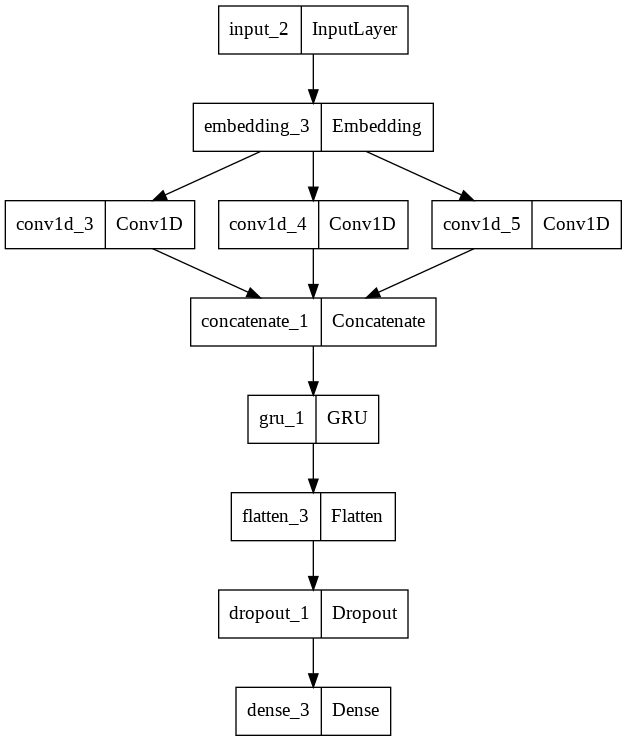

In [ ]:
tf.keras.utils.plot_model(conv_gru_model)

In [ ]:
conv_gru_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 512, 50)      8348000     ['input_2[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 256, 4)       1004        ['embedding_3[0][0]']            
                                                                                                  
 conv1d_4 (Conv1D)              (None, 256, 4)       1004        ['embedding_3[0][0]']            
                                                                                            

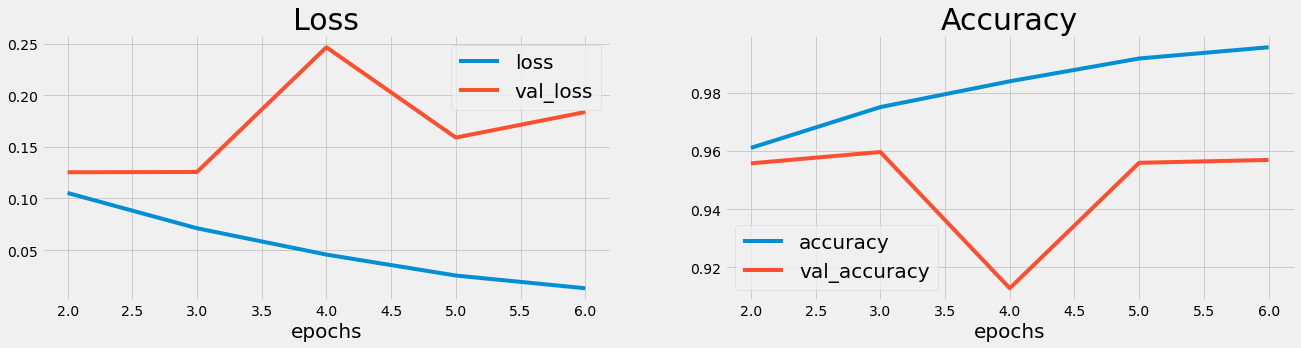

In [ ]:
accuracy_loss_plot(history3.history)

***12.3 prediction on test dataset***

In [ ]:
## get predictions
Y_train_pred_proba = conv_gru_model.predict(X_train_pad, verbose=0)
Y_valid_pred_proba = conv_gru_model.predict(X_valid_pad, verbose=0)

## get class labels
Y_train_pred = np.where(Y_train_pred_proba > 0.50, 1, 0)
Y_valid_pred = np.where(Y_valid_pred_proba > 0.50, 1, 0)

-------------------------------------Classification Report---------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4550
           1       0.84      0.75      0.79       575

    accuracy                           0.96      5125
   macro avg       0.90      0.86      0.88      5125
weighted avg       0.95      0.96      0.95      5125



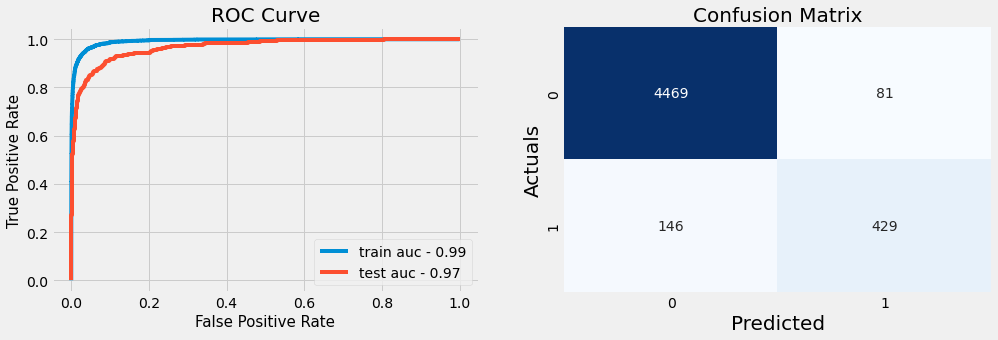

In [ ]:
score_conv_gru = get_scores('CONV GRU Model', Y_train, Y_valid,
                             Y_train_pred, Y_valid_pred,
                             Y_train_pred_proba, Y_valid_pred_proba)

get_plots(Y_train, Y_valid,
          Y_train_pred_proba, Y_valid_pred_proba,
          Y_train_pred, Y_valid_pred)

**13. Pre-Trained BERT Modelling**

In [ ]:
def bert_modelling():
    """
    This function sets up bert model.
    """
    ## bert model set-up
    input_layer = Input(shape=(), dtype=tf.string, name='text')
    preprocess_layer = bert_preprocess(input_layer)
    outputs = bert_encoder(preprocess_layer)
    
    ## dropout to prevent overfitting
    x = Dropout(0.2)(outputs['pooled_output'])

    ## final layer
    output = Dense(1, activation='sigmoid')(x)

    ## setting up final model
    model = tf.keras.Model(inputs=[input_layer], outputs = [output])

    ## compiling model
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

***13.1 Training Model***

In [ ]:
## set-up encoder and preprocessing object
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')

bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [ ]:
## setup training data
X_train_bert = train_df['text_preprocessed']
X_valid_bert = valid_df['text_preprocessed']
X_test_bert  = test_df['text_preprocessed']

In [ ]:
## saving model checkpoints
log_dir_checkpoint_v5 = os.path.join(CHECKPOINT_PATH, datetime.datetime.now().strftime("%H%M%S"))
checkpoint = ModelCheckpoint(log_dir_checkpoint_v5, monitor="val_loss", verbose=2,
                             save_best_only=True,)
print(log_dir_checkpoint_v5)

## early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=2, mode='auto') 

## setting up model
bert_model = bert_modelling()

## training model
history4 = bert_model.fit(X_train_bert, Y_train,
                          validation_data=(X_valid_bert, Y_valid),
                          batch_size=128, verbose=1, epochs=10, 
                          callbacks = [early_stop, checkpoint])

# get best model
bert_model.load_weights(log_dir_checkpoint_v5)

/content/drive/MyDrive/final_project/checkpoint/145152
Epoch 1/10
282/282 [==============================] - ETA: 0s - loss: 0.3524 - accuracy: 0.8782
Epoch 1: val_loss improved from inf to 0.33501, saving model to /content/drive/MyDrive/final_project/checkpoint/145152


282/282 [==============================] - 572s 2s/step - loss: 0.3524 - accuracy: 0.8782 - val_loss: 0.3350 - val_accuracy: 0.8870
Epoch 2/10
282/282 [==============================] - ETA: 0s - loss: 0.3144 - accuracy: 0.8883
Epoch 2: val_loss improved from 0.33501 to 0.31476, saving model to /content/drive/MyDrive/final_project/checkpoint/145152


282/282 [==============================] - 556s 2s/step - loss: 0.3144 - accuracy: 0.8883 - val_loss: 0.3148 - val_accuracy: 0.8868
Epoch 3/10
282/282 [==============================] - ETA: 0s - loss: 0.3016 - accuracy: 0.8886
Epoch 3: val_loss improved from 0.31476 to 0.30217, saving model to /content/drive/MyDrive/final_project/checkpoint/145152


282/282 [==============================] - 569s 2s/step - loss: 0.3016 - accuracy: 0.8886 - val_loss: 0.3022 - val_accuracy: 0.8870
Epoch 4/10
282/282 [==============================] - ETA: 0s - loss: 0.2925 - accuracy: 0.8895
Epoch 4: val_loss improved from 0.30217 to 0.28741, saving model to /content/drive/MyDrive/final_project/checkpoint/145152


282/282 [==============================] - 559s 2s/step - loss: 0.2925 - accuracy: 0.8895 - val_loss: 0.2874 - val_accuracy: 0.8872
Epoch 5/10
282/282 [==============================] - ETA: 0s - loss: 0.2872 - accuracy: 0.8905
Epoch 5: val_loss improved from 0.28741 to 0.28060, saving model to /content/drive/MyDrive/final_project/checkpoint/145152


282/282 [==============================] - 557s 2s/step - loss: 0.2872 - accuracy: 0.8905 - val_loss: 0.2806 - val_accuracy: 0.8890
Epoch 6/10
282/282 [==============================] - ETA: 0s - loss: 0.2822 - accuracy: 0.8924
Epoch 6: val_loss did not improve from 0.28060
282/282 [==============================] - 544s 2s/step - loss: 0.2822 - accuracy: 0.8924 - val_loss: 0.2829 - val_accuracy: 0.8882
Epoch 7/10
282/282 [==============================] - ETA: 0s - loss: 0.2786 - accuracy: 0.8932
Epoch 7: val_loss did not improve from 0.28060
282/282 [==============================] - 541s 2s/step - loss: 0.2786 - accuracy: 0.8932 - val_loss: 0.2816 - val_accuracy: 0.8888
Epoch 8/10
282/282 [==============================] - ETA: 0s - loss: 0.2773 - accuracy: 0.8939
Epoch 8: val_loss improved from 0.28060 to 0.27068, saving model to /content/drive/MyDrive/final_project/checkpoint/145152


282/282 [==============================] - 558s 2s/step - loss: 0.2773 - accuracy: 0.8939 - val_loss: 0.2707 - val_accuracy: 0.8907
Epoch 9/10
282/282 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.8948
Epoch 9: val_loss improved from 0.27068 to 0.26886, saving model to /content/drive/MyDrive/final_project/checkpoint/145152


282/282 [==============================] - 571s 2s/step - loss: 0.2740 - accuracy: 0.8948 - val_loss: 0.2689 - val_accuracy: 0.8905
Epoch 10/10
282/282 [==============================] - ETA: 0s - loss: 0.2730 - accuracy: 0.8949
Epoch 10: val_loss improved from 0.26886 to 0.26807, saving model to /content/drive/MyDrive/final_project/checkpoint/145152


282/282 [==============================] - 558s 2s/step - loss: 0.2730 - accuracy: 0.8949 - val_loss: 0.2681 - val_accuracy: 0.8929


***13.2 Validation Plots***

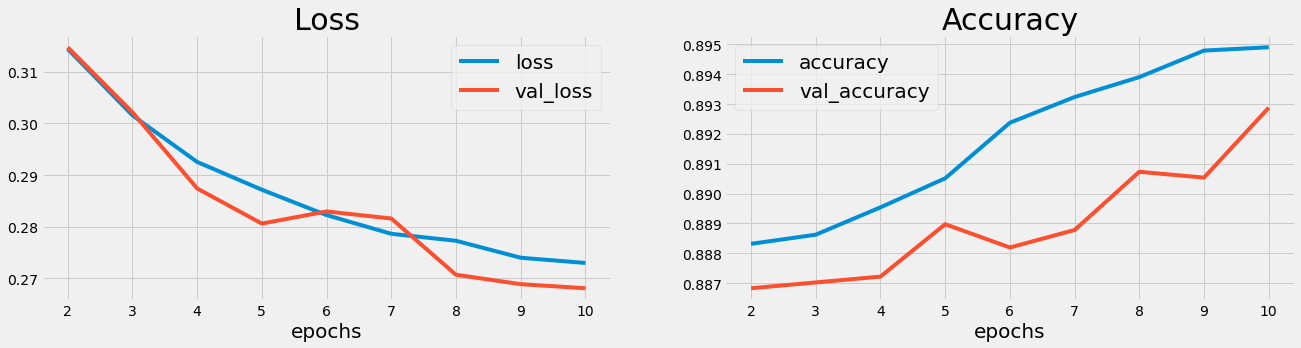

In [ ]:
accuracy_loss_plot(history4.history)

***13.3 prediction on test dataset***

In [ ]:
## get predictions
Y_train_pred_proba = bert_model.predict(X_train_bert, verbose=1).flatten()
Y_valid_pred_proba = bert_model.predict(X_valid_bert, verbose=1).flatten()

## get class labels
Y_train_pred = np.where(Y_train_pred_proba > 0.50, 1, 0)
Y_valid_pred = np.where(Y_valid_pred_proba > 0.50, 1, 0)

161/161 [==============================] - 54s 334ms/step


-------------------------------------Classification Report---------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      4550
           1       0.59      0.15      0.24       575

    accuracy                           0.89      5125
   macro avg       0.75      0.57      0.59      5125
weighted avg       0.87      0.89      0.86      5125



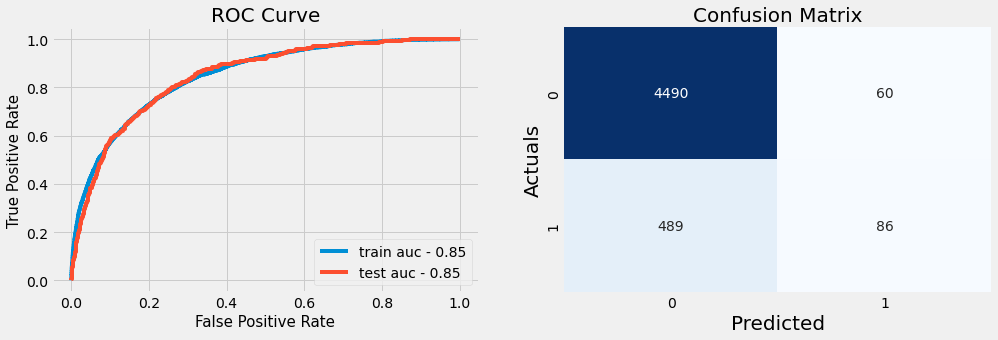

In [ ]:
score_bert = get_scores('BERT Model', Y_train, Y_valid,
                             Y_train_pred, Y_valid_pred,
                             Y_train_pred_proba, Y_valid_pred_proba)

get_plots(Y_train, Y_valid,
          Y_train_pred_proba, Y_valid_pred_proba,
          Y_train_pred, Y_valid_pred)

**14. Output Comparison**

In [ ]:
final_scores = pd.DataFrame()

final_scores = final_scores.append(score_lstm, ignore_index=True)
final_scores = final_scores.append(score_gru, ignore_index=True)
final_scores = final_scores.append(score_conv_lstm, ignore_index=True)
final_scores = final_scores.append(score_conv_gru, ignore_index=True)
final_scores = final_scores.append(score_bert, ignore_index=True)

In [ ]:
## dump data
final_scores.to_csv(os.path.join(FOLDER_PATH, 'model_output_scores_dl.csv'), index=False)

In [ ]:
## get sorted rows to select best model
final_scores.sort_values(by = ['propaganda_accuracy', 'recall'],ascending=False)

,model_name,accuracy,auc,not_propaganda_accuracy,propaganda_accuracy,f1,precision,recall,roc
2,CONV LSTM Model,0.9551,0.9701,0.9758,0.7913,0.7982,0.8053,0.7913,0.8836
0,LSTM Model,0.9592,0.9704,0.9809,0.7878,0.8126,0.8389,0.7878,0.8844
3,CONV GRU Model,0.9557,0.9671,0.9822,0.7461,0.7908,0.8412,0.7461,0.8641
1,GRU Model,0.9590,0.9687,0.9866,0.7409,0.8023,0.8747,0.7409,0.8637
4,BERT Model,0.8929,0.8467,0.9868,0.1496,0.2386,0.5890,0.1496,0.5682


**Best Model Selection**


1. The best model is - **Convolution LSTM Model**

2. The convolution LSTM based model has beaten all other deep learning models including bert and also machine learning models.

3. The minority class accuracy is 79.82% which is 7% more than the best machine learning model and little bit more than LSTM model.

In [ ]:
## creating output score bar graph for top 10 models
dl_score = pd.read_csv(os.path.join(FOLDER_PATH, 'model_output_scores_dl.csv'))
ml_score = pd.read_csv(os.path.join(FOLDER_PATH, 'model_output_scores.csv'))

final_data = pd.concat([ml_score, dl_score])

## get sorted rows to select best model
top_10_outputs = final_data.sort_values(by = ['propaganda_accuracy', 'recall'],ascending=False).iloc[0:10]

**15. Visualization**

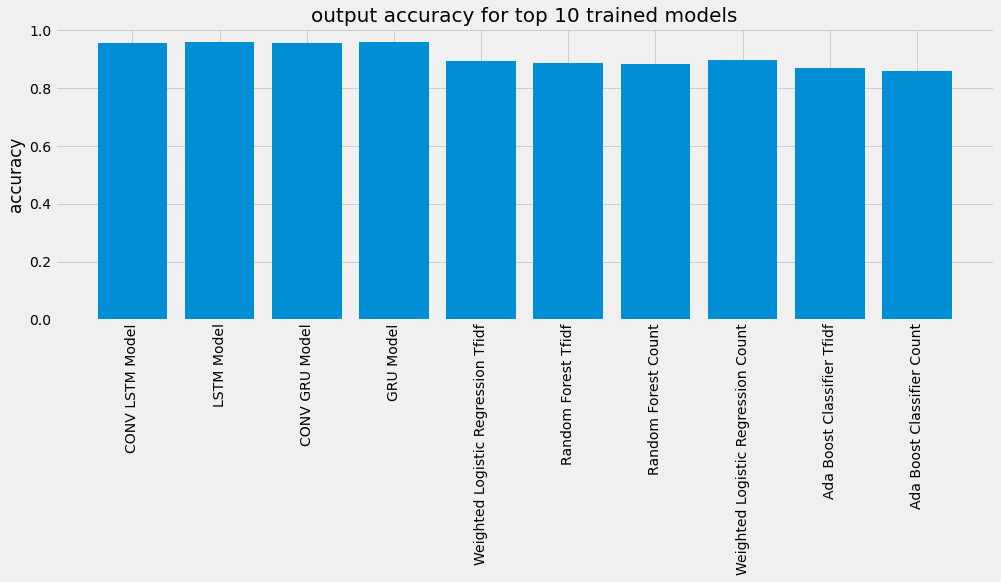

In [ ]:
plt.figure(figsize=(15,5))
plt.bar(top_10_outputs['model_name'].values, top_10_outputs['accuracy'].values)
plt.title("output accuracy for top 10 trained models", fontsize=20)
plt.ylabel('accuracy')
plt.xticks(rotation=90)
plt.show()